Using these 6 bag files:
  day_01: /home/dat/Downloads/data/MCDVIRAL/ntu_day_01/ntu_day_01_ltpb.bag
  day_02: /home/dat/Downloads/data/MCDVIRAL/ntu_day_02/ntu_day_02_ltpb.bag
  day_10: /home/dat/Downloads/data/MCDVIRAL/ntu_day_10/ntu_day_10_ltpb.bag
  night_04: /home/dat/Downloads/data/MCDVIRAL/ntu_night_04/ntu_night_04_ltpb.bag
  night_08: /home/dat/Downloads/data/MCDVIRAL/ntu_night_08/ntu_night_08_ltpb.bag
  night_13: /home/dat/Downloads/data/MCDVIRAL/ntu_night_13/ntu_night_13_ltpb.bag


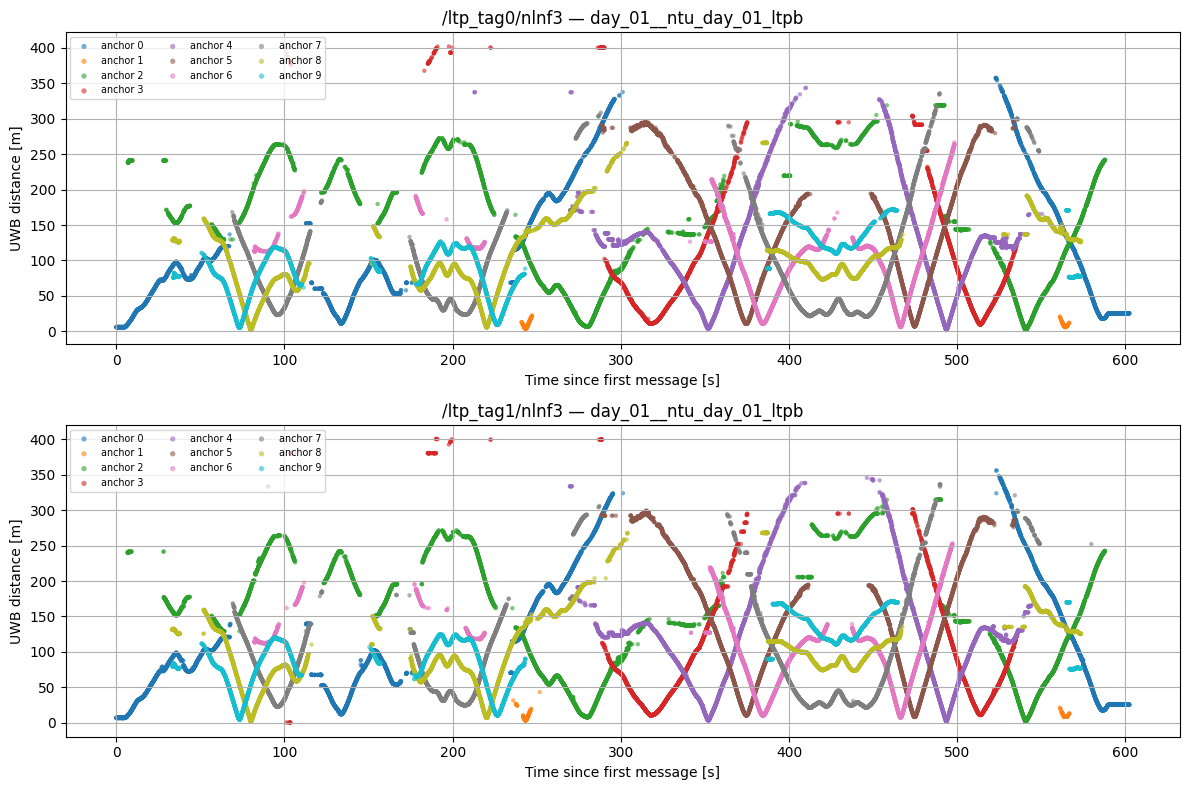

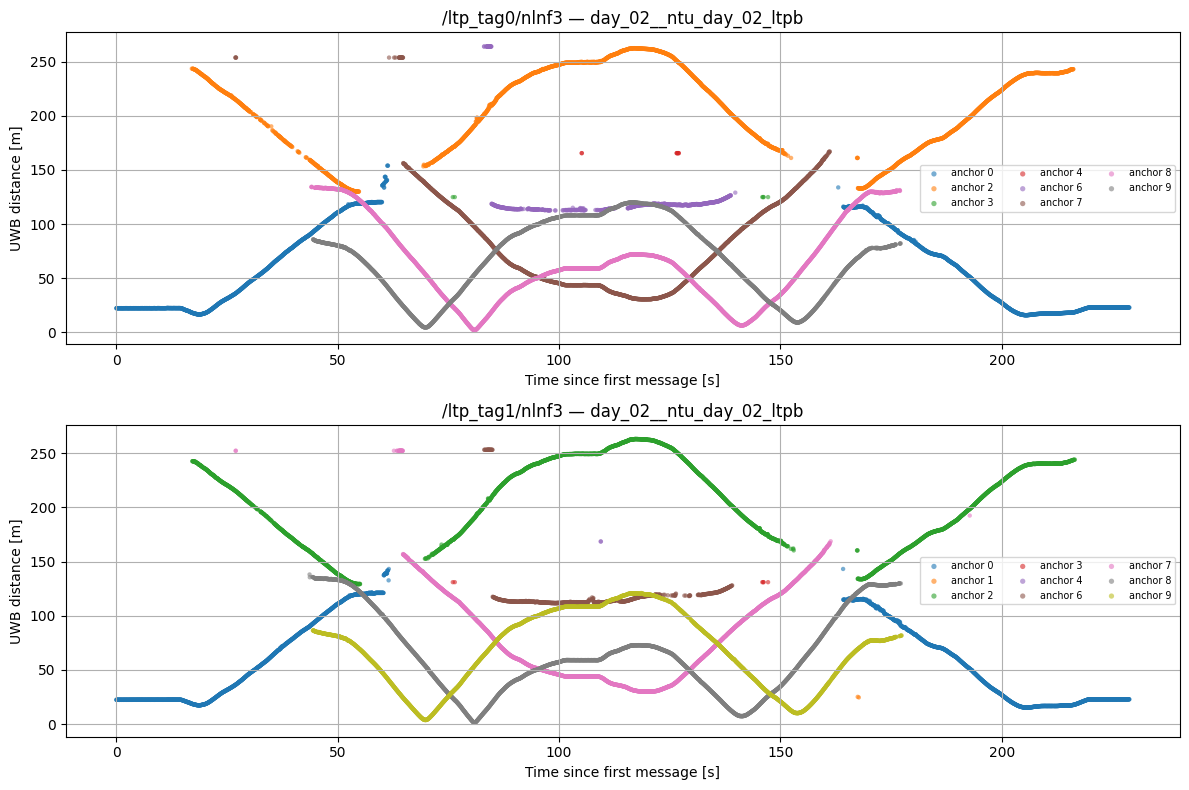

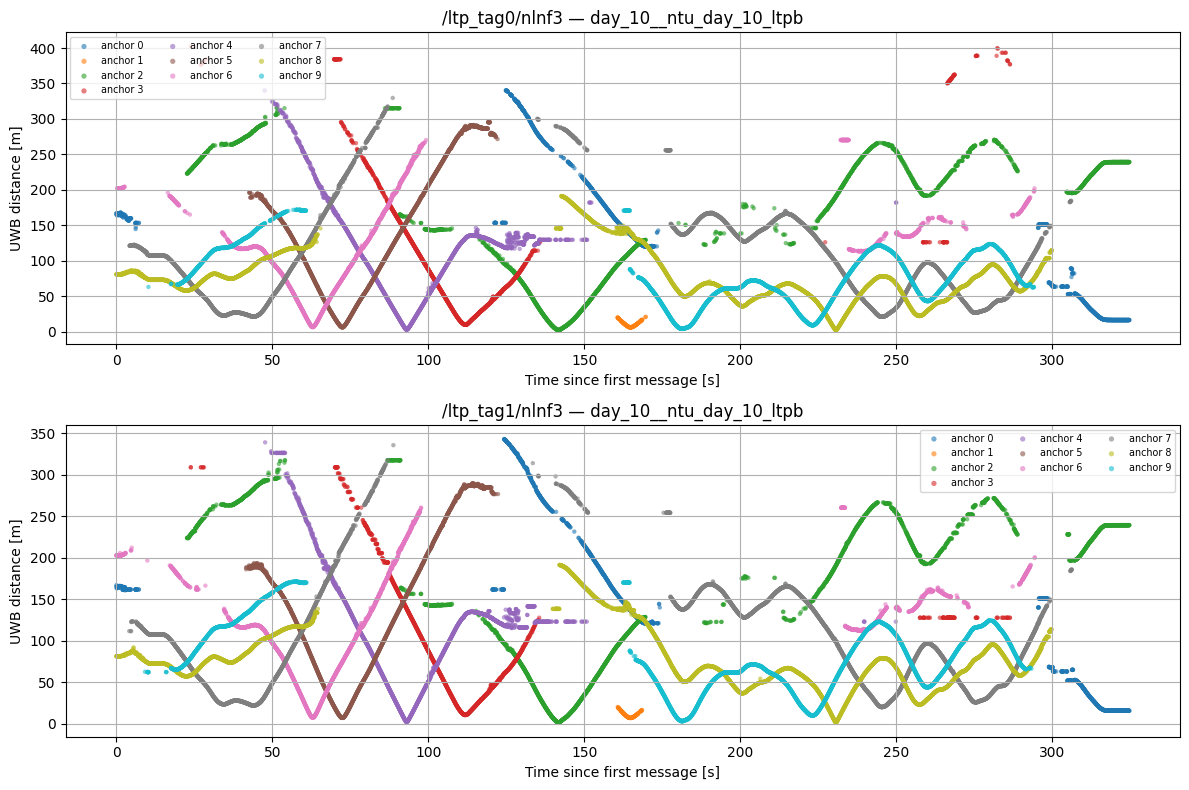

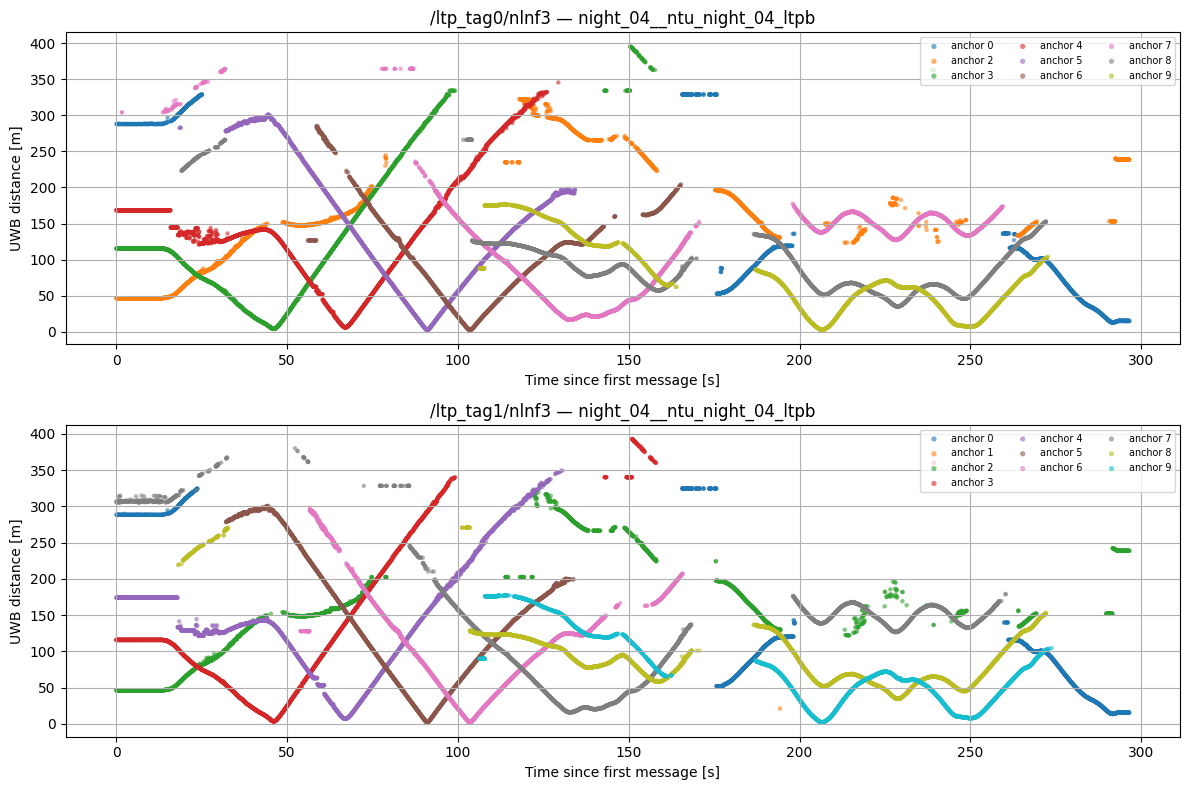

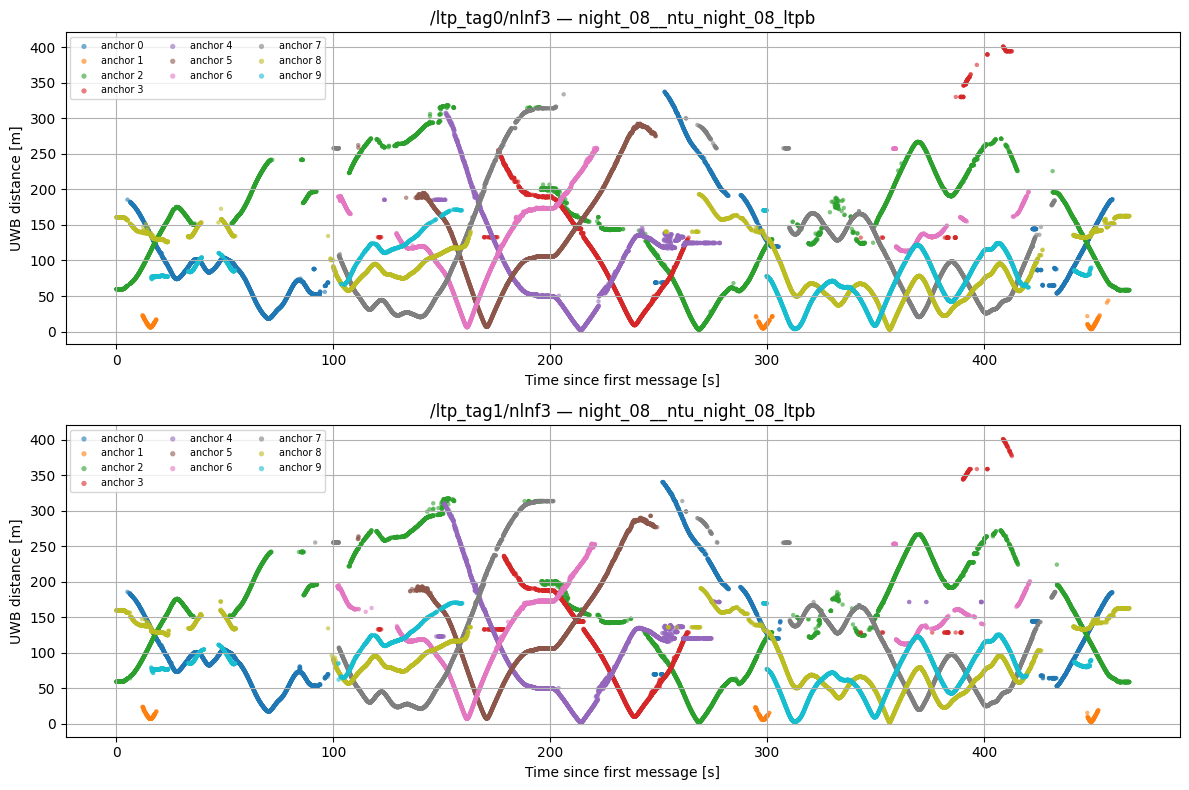

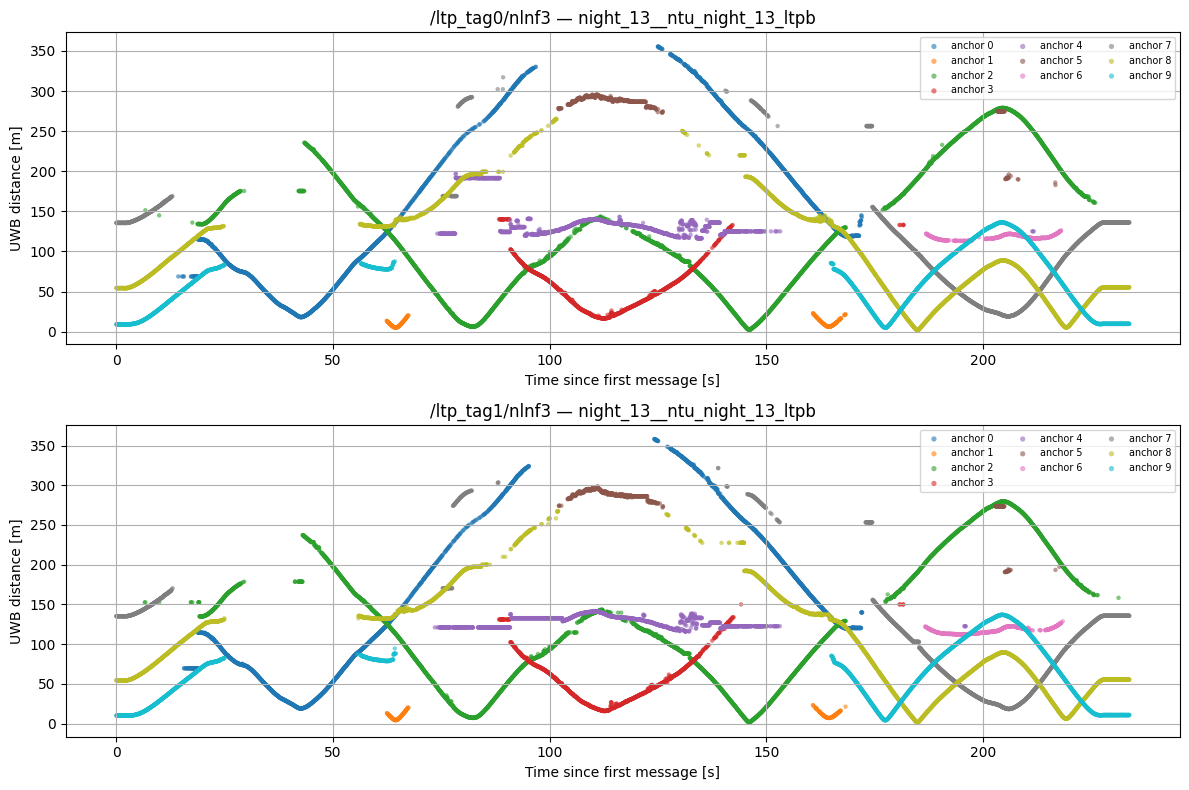

In [31]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

# === USER CONFIGURATION ===
BASE_DIR = "/home/dat/Downloads/data/MCDVIRAL"  # nơi chứa các thư mục / bag
TARGET_IDS = ["day_01", "day_02", "day_10", "night_04", "night_08", "night_13"]  # đúng 6
TOPICS = ["/ltp_tag0/nlnf3", "/ltp_tag1/nlnf3"]
ANCHORS = "0,1,2,3,4,5,6,7,8,9"
OUTPUT_DIR = None  # hoặc "figs" để lưu ảnh
SHOW_INLINE = True
PER_TOPIC_SEPARATE = False
# === END CONFIG ===

# ROS dependency (must be run in sourced ROS environment)
try:
    import rosbag
except ImportError:
    raise ImportError("rosbag module not found. Source your ROS environment (e.g., `source /opt/ros/noetic/setup.bash`) before running.")

# optional import of message type
try:
    from nlink_parser.msg import LinktrackNodeframe3  # noqa: F401
except Exception:
    pass  # proceed anyway

def parse_anchor_list(s):
    if s is None:
        return None
    if isinstance(s, (list, tuple)):
        return [int(x) for x in s]
    if isinstance(s, str):
        try:
            return [int(x.strip()) for x in s.split(',') if x.strip() != ""]
        except ValueError:
            print(f"WARNING: bad anchor list '{s}', ignoring filter.")
            return None
    return None

def safe_topic_to_name(topic):
    return topic.strip("/").replace("/", "_")

def find_exact_six_bags(base_dir, target_ids):
    """
    For each target_id like 'night_13', find files matching 'ntu_{target_id}_*.bag' anywhere under base_dir.
    Prefer filenames containing 'ltpb'; if multiple, pick first sorted. Raises if any missing.
    Returns list of (bag_path, target_id) in the order of target_ids.
    """
    result = []
    for tid in target_ids:
        pattern = os.path.join(base_dir, "**", f"ntu_{tid}_*.bag")
        candidates = sorted(glob.glob(pattern, recursive=True))
        if not candidates:
            raise FileNotFoundError(f"No bag found for pattern 'ntu_{tid}_*.bag' under {base_dir}")
        # prefer containing 'ltpb'
        chosen = None
        for c in candidates:
            if "ltpb" in os.path.basename(c).lower():
                chosen = c
                break
        if chosen is None:
            chosen = candidates[0]
        result.append((chosen, tid))
    return result  # list of tuples

def load_uwb_distances(bag_path, topic, anchors=None):
    anchor_filter = parse_anchor_list(anchors)
    distances = {}
    first_time = None
    saw_any = False
    if not os.path.isfile(bag_path):
        print(f"ERROR: bag not found: {bag_path}")
        return {}
    try:
        bag = rosbag.Bag(bag_path, "r")
    except Exception as e:
        print(f"ERROR opening bag {bag_path}: {e}")
        return {}

    for topic_name, msg, t in bag.read_messages(topics=[topic]):
        saw_any = True
        try:
            msg_time = msg.header.stamp.to_sec()
        except Exception:
            msg_time = t.to_sec()
        if first_time is None:
            first_time = msg_time
        rel_time = msg_time - first_time

        if not hasattr(msg, "nodes"):
            continue
        for node in msg.nodes:
            aid = getattr(node, "id", None)
            dis = getattr(node, "dis", None)
            if aid is None or dis is None:
                continue
            if dis < 0:
                continue
            if (anchor_filter is not None) and (aid not in anchor_filter):
                continue
            if aid not in distances:
                distances[aid] = {"times": [], "dists": []}
            distances[aid]["times"].append(rel_time)
            distances[aid]["dists"].append(dis)
    bag.close()
    if not saw_any:
        print(f"WARNING: no messages on topic '{topic}' in {os.path.basename(bag_path)}")
    if len(distances) == 0:
        print(f"No valid distance data for topic '{topic}' in {os.path.basename(bag_path)}")
    return distances

def plot_six_bags(bag_info_list, topics, anchors=None, output_dir=None, show_inline=True, per_topic_separate=False):
    anchor_filter = parse_anchor_list(anchors)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    for bag_path, tid in bag_info_list:
        base = os.path.splitext(os.path.basename(bag_path))[0]
        title_id = f"{tid}__{base}"
        fig, axes = plt.subplots(len(topics), 1, figsize=(12, 4 * len(topics)), squeeze=False)
        for idx, topic in enumerate(topics):
            distances = load_uwb_distances(bag_path, topic, anchors=anchor_filter)
            ax = axes[idx][0] if axes.ndim > 1 else axes[idx]
            if not distances:
                ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=12)
                ax.set_title(f"{topic} — {title_id}")
                continue
            for aid, data in sorted(distances.items()):
                times = np.array(data["times"])
                dists = np.array(data["dists"])
                ax.scatter(times, dists, s=10, alpha=0.6, label=f"anchor {aid}", edgecolors="none")
            ax.set_xlabel("Time since first message [s]")
            ax.set_ylabel("UWB distance [m]")
            ax.set_title(f"{topic} — {title_id}")
            ax.grid(True)
            ax.legend(fontsize="x-small", markerscale=1.2, ncols=3)
        plt.tight_layout()
        if output_dir:
            out_path = os.path.join(output_dir, f"{title_id}_multi_topic.png")
            fig.savefig(out_path, dpi=200)
            print(f"[saved] {out_path}")
        if show_inline:
            plt.show()
        else:
            plt.close(fig)

        if per_topic_separate:
            for topic in topics:
                distances = load_uwb_distances(bag_path, topic, anchors=anchor_filter)
                if not distances:
                    continue
                fig2, ax2 = plt.subplots(figsize=(12, 4))
                for aid, data in sorted(distances.items()):
                    times = np.array(data["times"])
                    dists = np.array(data["dists"])
                    ax2.scatter(times, dists, s=10, alpha=0.6, label=f"anchor {aid}", edgecolors="none")
                ax2.set_xlabel("Time since first message [s]")
                ax2.set_ylabel("UWB distance [m]")
                ax2.set_title(f"{topic} — {title_id}")
                ax2.grid(True)
                ax2.legend(fontsize="x-small", markerscale=1.2, ncols=3)
                plt.tight_layout()
                if output_dir:
                    topic_name = safe_topic_to_name(topic)
                    out_path2 = os.path.join(output_dir, f"{title_id}_{topic_name}.png")
                    fig2.savefig(out_path2, dpi=200)
                    print(f"[saved] {out_path2}")
                if show_inline:
                    plt.show()
                else:
                    plt.close(fig2)

# === RUN ===
try:
    bag_info = find_exact_six_bags(BASE_DIR, TARGET_IDS)
except FileNotFoundError as e:
    print("ERROR:", e)
    raise

print("Using these 6 bag files:")
for p, tid in bag_info:
    print(f"  {tid}: {p}")

plot_six_bags(
    bag_info_list=bag_info,
    topics=TOPICS,
    anchors=ANCHORS,
    output_dir=OUTPUT_DIR,
    show_inline=SHOW_INLINE,
    per_topic_separate=PER_TOPIC_SEPARATE
)
